# Scenario Analysis

This Jupyter notebook (Python 3 kernel) assesses GEOCLIM output for the various scenarios explored in this study.

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# additional imports
from tqdm.notebook import tqdm
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Read in Files

In [2]:
# read in the files
path = '/Volumes/GEOCLIM/modern_scenario_outputs/'

control_nc = Dataset(path+'ctrl_backward.nc')

noIA_nc = Dataset(path+'noIA.nc')

redIA_nc = Dataset(path+'redIA.nc')
redIA10_nc = Dataset(path+'redIA10.nc')
redIA5_nc = Dataset(path+'redIA5.nc')

redIAsunda_nc = Dataset(path+'redIAsunda.nc')
redIAsunda10_nc = Dataset(path+'redIAsunda10.nc')
redIAsunda5_nc = Dataset(path+'redIAsunda5.nc')

redIAsundaGL_nc = Dataset(path+'redIAsundaGL.nc')
redIAsunda10GL_nc = Dataset(path+'redIAsunda10GL.nc')
redIAsunda5GL_nc = Dataset(path+'redIAsunda5GL.nc')

noDeccan_nc = Dataset(path+'noDeccan.nc')
noET_nc = Dataset(path+'noET.nc')
noTraps_nc = Dataset(path+'noTraps.nc')
noCRB_nc = Dataset(path+'noCRB.nc')

test_params = pd.read_csv('../Output/test_params.csv')

In [3]:
noIA_nc.variables.keys()

dict_keys(['lon', 'lat', 'lith', 'runs', 'area', 'lithology_fraction', 'atm_CO2_level', 'volcanic_degassing', 'temperature', 'runoff', 'slope', 'erosion', 'reg_thickness', 'weathering', 'x_p_surf'])

In [4]:
test_params.columns

Index(['ke', 'a', 'b', 'krp', 'Ea_rp', 'T0_rp', 'h0', 'kd', 'kw', 'Ea', 'T0',
       'sigma', 'CaMg_1', 'CaMg_2', 'CaMg_3', 'CaMg_4', 'CaMg_5', 'CaMg_6',
       'R2'],
      dtype='object')

Change the R$^{2}$ threshold to 0.5:

In [5]:
test_params_0_5 = test_params[test_params['R2']>0.5]
inds_0_5 = test_params_0_5.index

Compile:

In [6]:
refresh = False

if refresh:

    compiled_df = test_params_0_5.copy()
    compiled_df['volcanic_degassing'] = redIA_nc.variables['volcanic_degassing'][:].data[inds_0_5]

    compiled_df['control_ppm'] = control_nc.variables['atm_CO2_level'][:].data[inds_0_5]

    compiled_df['noIA_ppm'] = noIA_nc.variables['atm_CO2_level'][:].data[inds_0_5]

    compiled_df['redIA_ppm'] = redIA_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['redIA10_ppm'] = redIA10_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['redIA5_ppm'] = redIA5_nc.variables['atm_CO2_level'][:].data[inds_0_5]

    compiled_df['redIAsunda_ppm'] = redIAsunda_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['redIAsunda10_ppm'] = redIAsunda10_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['redIAsunda5_ppm'] = redIAsunda5_nc.variables['atm_CO2_level'][:].data[inds_0_5]

    compiled_df['redIAsundaGL_ppm'] = redIAsundaGL_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['redIAsunda10GL_ppm'] = redIAsunda10GL_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['redIAsunda5GL_ppm'] = redIAsunda5GL_nc.variables['atm_CO2_level'][:].data[inds_0_5]

    compiled_df['noDeccan_ppm'] = noDeccan_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['noET_ppm'] = noET_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['noTraps_ppm'] = noTraps_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    compiled_df['noCRB_ppm'] = noCRB_nc.variables['atm_CO2_level'][:].data[inds_0_5]
    
    compiled_df.to_csv('../Output/scenario_analysis.csv', index=False)
    
else:
    
    compiled_df = pd.read_csv('../Output/scenario_analysis.csv')

compiled_df_scenario_list = ['control_ppm',
                             'noIA_ppm',
                             'redIA_ppm',
                             'redIA10_ppm',
                             'redIA5_ppm',
                             'redIAsunda_ppm',
                             'redIAsunda10_ppm',
                             'redIAsunda5_ppm',
                             'redIAsundaGL_ppm',
                             'redIAsunda10GL_ppm',
                             'redIAsunda5GL_ppm',
                             'noDeccan_ppm',
                             'noET_ppm',
                             'noTraps_ppm',
                             'noCRB_ppm']

## Plots

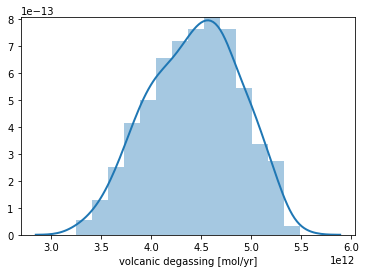

In [7]:
fig, ax = plt.subplots()

sns.distplot(compiled_df['volcanic_degassing'], ax=ax,
             kde_kws={'linewidth':2})
ax.set_xlabel('volcanic degassing [mol/yr]')

plt.show(fig)

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


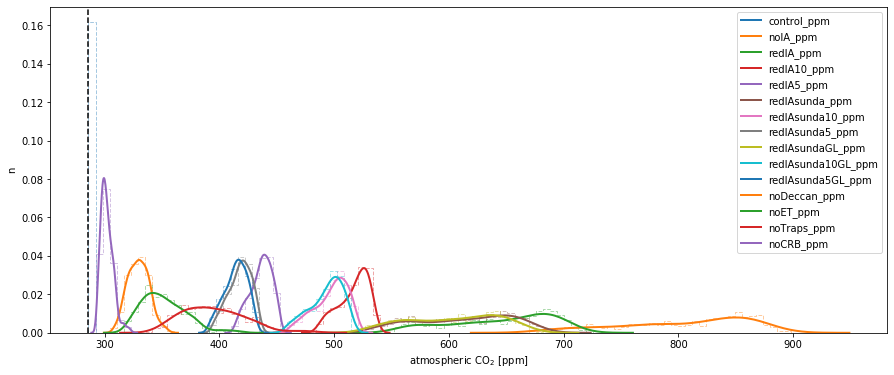

In [8]:
fig, ax = plt.subplots(figsize=(15,6))

bins = np.linspace(np.min(compiled_df[compiled_df_scenario_list].values),
                   np.max(compiled_df[compiled_df_scenario_list].values),
                   100)

for i in range(len(compiled_df_scenario_list)):
    
    sns.distplot(compiled_df[compiled_df_scenario_list[i]], bins=bins,
                 hist_kws={'color':'C'+str(i), 'linestyle':'--', 'histtype':'step'},
                 kde_kws={'color':'C'+str(i), 'linewidth':2, 'label':compiled_df_scenario_list[i]},
                 ax=ax)
    

ax.axvline(286, c='k', ls='--')

ax.set_xlabel('atmospheric CO$_{2}$ [ppm]')
ax.set_ylabel('n')
ax.legend()

plt.show(fig)

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

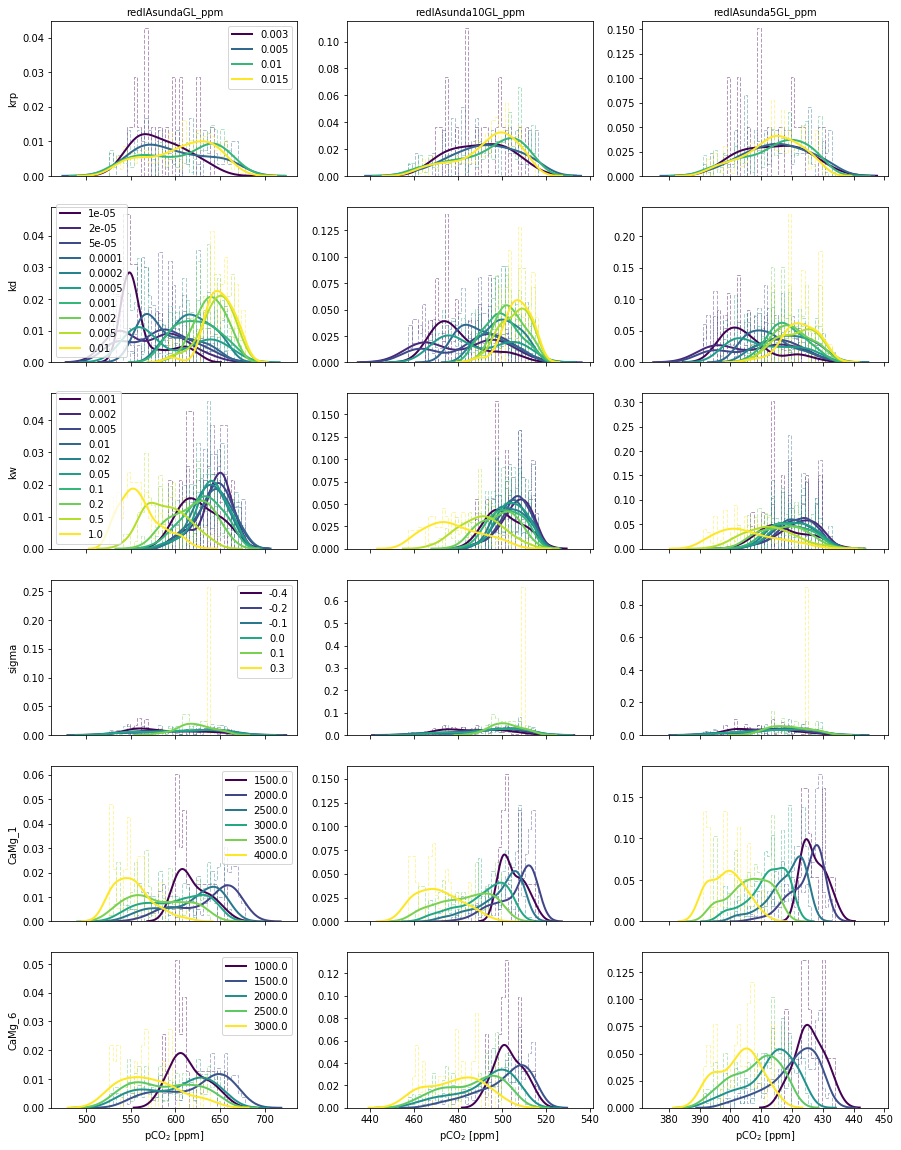

In [9]:
param_cols = ['krp','kd','kw','sigma','CaMg_1','CaMg_6']
distplot_scenario_list = ['redIAsundaGL_ppm','redIAsunda10GL_ppm','redIAsunda5GL_ppm']

fig, ax = plt.subplots(nrows=len(param_cols), ncols=len(distplot_scenario_list),
                       sharex='col', figsize=(15,20))

cmap = matplotlib.cm.get_cmap('viridis')

for i in range(len(param_cols)):
    
    unique_vals = compiled_df[param_cols[i]].unique()
    unique_vals = np.sort(unique_vals)
    
    colors = cmap(np.linspace(0,1,len(unique_vals)))
    
    for j in range(len(distplot_scenario_list)):
        
        bins = np.linspace(np.min(compiled_df[distplot_scenario_list[j]].values),
                           np.max(compiled_df[distplot_scenario_list[j]].values),
                           40)
        
        for k in range(len(unique_vals)):
            
            sns.distplot(compiled_df[compiled_df[param_cols[i]]==unique_vals[k]][distplot_scenario_list[j]],
                         bins=bins,
                         hist_kws={'color':colors[k], 'linestyle':'--', 'histtype':'step'},
                         kde_kws={'color':colors[k], 'linewidth':2, 'label':np.round(unique_vals[k],7)},
                         ax=ax[i][j])
            ax[i][j].set_xlabel('')
            ax[i][j].get_legend().remove()
            
        if i==0:
            ax[i][j].set_title(distplot_scenario_list[j], fontsize=10)
            
        if i==len(param_cols)-1:
            ax[i][j].set_xlabel('pCO$_{2}$ [ppm]')
            
        if j==0:
            ax[i][j].set_ylabel(param_cols[i])
            ax[i][j].legend()

plt.show(fig)

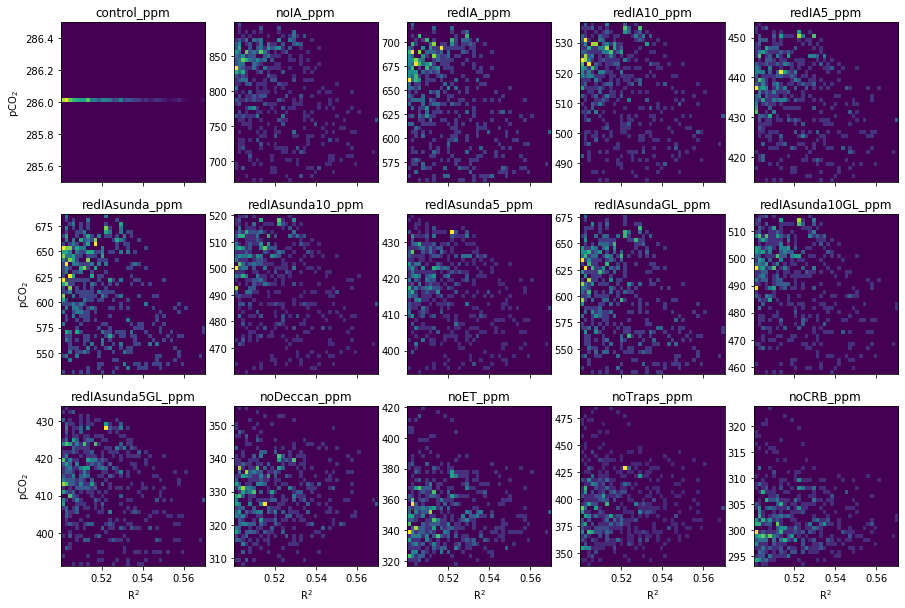

In [10]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(15,10), sharex=True)

ax = ax.flatten()

for i in range(len(compiled_df_scenario_list)):
    heatmap, xedges, yedges = np.histogram2d(compiled_df['R2'], compiled_df[compiled_df_scenario_list[i]],
                                             bins=40)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax[i].imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
    ax[i].set_title(compiled_df_scenario_list[i])
    
    if i in [0,5,10]:
        ax[i].set_ylabel('pCO$_{2}$')
        
    if i >=10:
        ax[i].set_xlabel('R$^{2}$')
        
    ax[0].set_xlim(np.min(compiled_df['R2']),np.max(compiled_df['R2']))
    
plt.show(fig)

In [11]:
R2_thresholds = np.arange(0.5,0.55,0.01)

R2_thresholds_test = pd.DataFrame({'threshold':R2_thresholds})

for i in range(len(R2_thresholds)):
    compiled_df_slice = compiled_df[compiled_df['R2']>=R2_thresholds[i]]
    
    for j in range(len(compiled_df_scenario_list)):
        pCO2_mean = np.mean(compiled_df_slice[compiled_df_scenario_list[j]])
        pCO2_02_5 = np.percentile(compiled_df_slice[compiled_df_scenario_list[j]], 2.5)
        pCO2_97_5 = np.percentile(compiled_df_slice[compiled_df_scenario_list[j]], 97.5)
        pCO2_n = len(compiled_df_slice[compiled_df_scenario_list[j]])
        
        R2_thresholds_test.loc[i,compiled_df_scenario_list[j]+'_mean'] = pCO2_mean
        R2_thresholds_test.loc[i,compiled_df_scenario_list[j]+'_02_5'] = pCO2_02_5
        R2_thresholds_test.loc[i,compiled_df_scenario_list[j]+'_97_5'] = pCO2_97_5
        R2_thresholds_test.loc[i,compiled_df_scenario_list[j]+'_n'] = pCO2_n

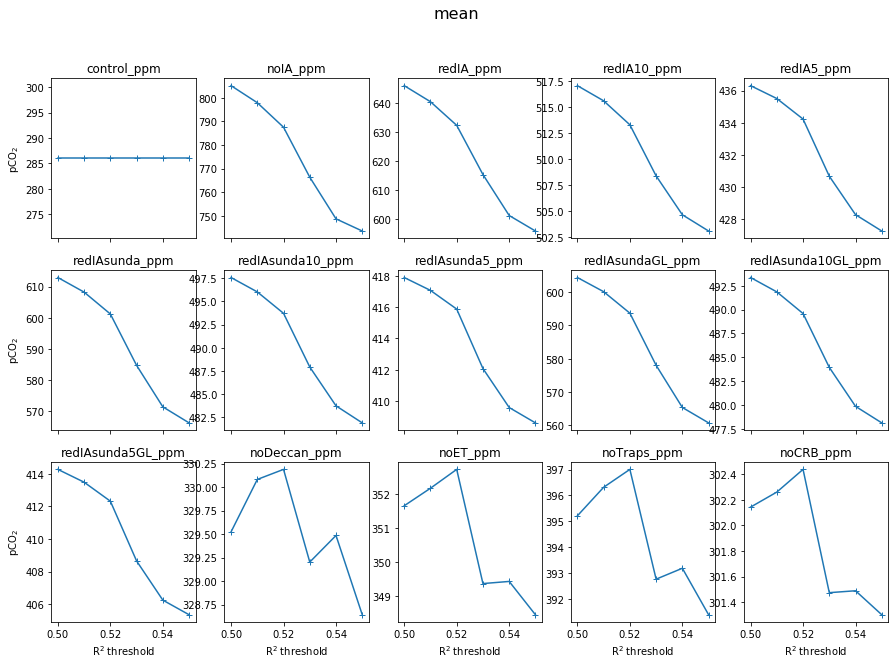

In [12]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(15,10), sharex=True)

ax = ax.flatten()

for i in range(len(compiled_df_scenario_list)):
    
    ax[i].plot(R2_thresholds_test['threshold'], R2_thresholds_test[compiled_df_scenario_list[i]+'_mean'],
               '+-')
    ax[i].set_title(compiled_df_scenario_list[i])
    
    if i in [0,5,10]:
        ax[i].set_ylabel('pCO$_{2}$')
        
    if i >=10:
        ax[i].set_xlabel('R$^{2}$ threshold')
    
fig.suptitle('mean', fontsize=16)

plt.show(fig)

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kde_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hist_color != color:
/Users/yuempark/anaconda3/lib/python3.7/site-packages/seab

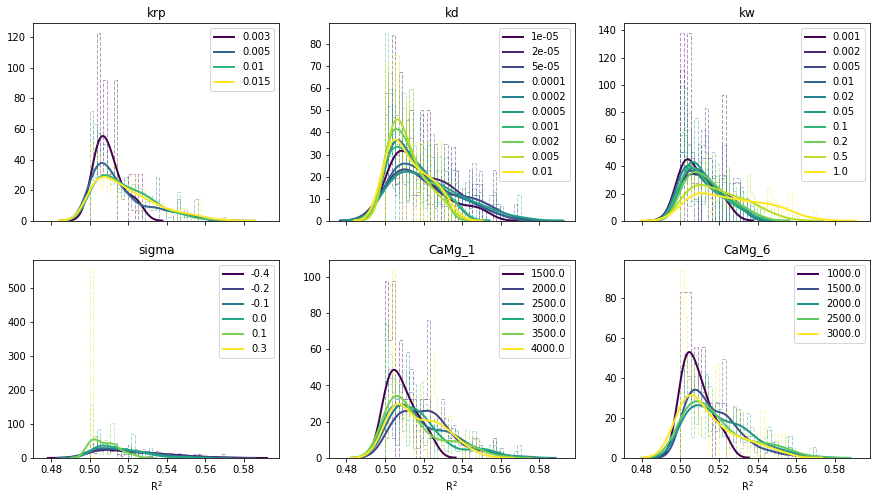

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8), sharex=True)

bins = np.linspace(np.min(compiled_df['R2']), np.max(compiled_df['R2']), 40)

ax = ax.flatten()

cmap = matplotlib.cm.get_cmap('viridis')

for i in range(len(param_cols)):
    unique_vals = np.array(compiled_df[param_cols[i]].unique())
    unique_vals = np.sort(unique_vals)
    
    colors = cmap(np.linspace(0,1,len(unique_vals)))
    
    for j in range(len(unique_vals)):
        sns.distplot(compiled_df['R2'][compiled_df[param_cols[i]]==unique_vals[j]],
                     bins=bins, hist=True,
                     hist_kws={'color':colors[j], 'linestyle':'--', 'histtype':'step'},
                     kde_kws={'color':colors[j], 'linewidth':2, 'label':np.round(unique_vals[j],7)},
                     ax=ax[i])
    ax[i].legend()
    ax[i].set_title(param_cols[i])
    
    if i>=3:
        ax[i].set_xlabel('R$^{2}$')
    else:
        ax[i].set_xlabel('')
    
plt.show(fig)

## PCA

In [14]:
# get a dataframe with just the changing parameters
stat_cols = ['krp','kd','kw','sigma','CaMg_1','CaMg_6','R2','volcanic_degassing','redIAsundaGL_ppm']
stat_df = compiled_df[stat_cols].copy()

# standardize
scaler = StandardScaler()
stat_df = scaler.fit_transform(stat_df)
stat_df = pd.DataFrame(data=stat_df, columns=stat_cols)

# PCA
pca = PCA()
PCA_Y = pca.fit_transform(stat_df)

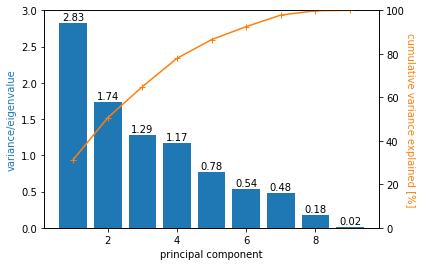

In [15]:
fig, ax = plt.subplots()

rects = ax.bar(np.arange(len(pca.explained_variance_))+1, pca.explained_variance_, color='C0')
ax.set_ylabel('variance/eigenvalue', color='C0')
ax.set_xlabel('principal component')
ax.set_ylim(0,3)

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, '-+', color='C1')
twinax.set_ylim(0,100)
twinax.set_ylabel('cumulative variance explained [%]', rotation=270, color='C1', labelpad=10)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            ax.text(rect.get_x() + rect.get_width()/2, height+0.08,
                    np.round(height,2),
                    ha='center', va='center')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height-0.08,
                    np.round(height,2),
                    ha='center', va='center')
            
autolabel(rects)

plt.show(fig)

In [16]:
N = len(stat_cols)
for i in range(N):
    print('PC' + str(i+1) + ': ' + str(np.round(pca.explained_variance_ratio_[i]*100,1)) + '%')

PC1: 31.4%
PC2: 19.3%
PC3: 14.3%
PC4: 13.0%
PC5: 8.6%
PC6: 6.0%
PC7: 5.3%
PC8: 2.0%
PC9: 0.2%


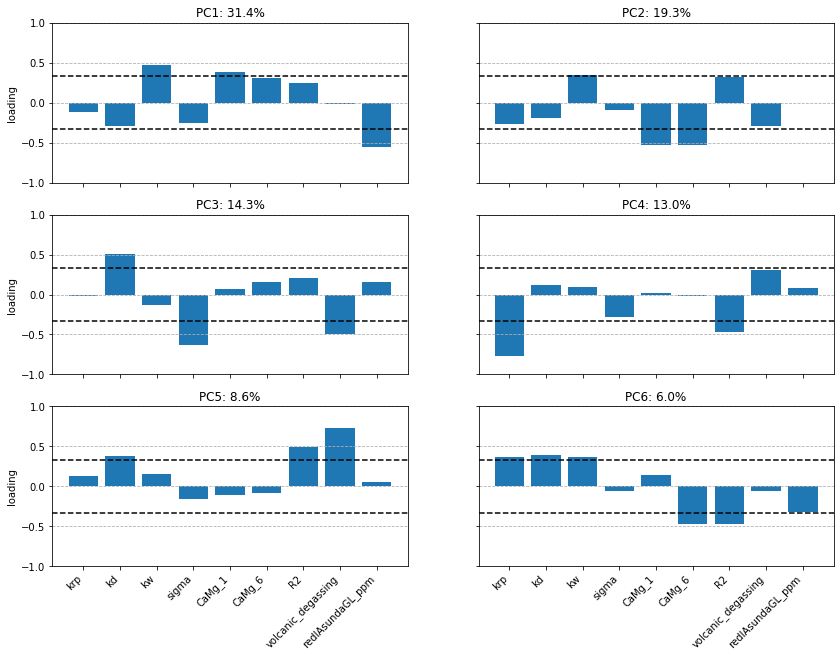

In [17]:
ind = np.arange(N)

component_names = []
for i in range(len(stat_cols)):
    component_names.append('PC ' + str(i+1))

eigenvectors = pd.DataFrame(pca.components_.T, columns=component_names, index=stat_cols)

cutoff = np.sqrt(1/len(stat_cols))

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,10), sharey=True, sharex=True)

ax = ax.flatten()

for i in range(6):
    ax[i].bar(ind, eigenvectors['PC ' + str(i+1)], color='C0')
    ax[i].set_ylim(-1,1)
    ax[i].yaxis.grid(ls='--')
    ax[i].axhline(cutoff, ls='--', c='k')
    ax[i].axhline(-cutoff, ls='--', c='k')
    ax[i].set_title('PC' + str(i+1) + ': ' + str(np.round(pca.explained_variance_ratio_[i]*100,1)) + '%')
    ax[i].set_xticklabels([])
    
ax[4].set_xticks(ind)
ax[4].set_xticklabels(stat_cols, rotation=45, ha='right')
ax[5].set_xticks(ind)
ax[5].set_xticklabels(stat_cols, rotation=45, ha='right')

ax[0].set_ylabel('loading')
ax[2].set_ylabel('loading')
ax[4].set_ylabel('loading')

plt.show(fig)

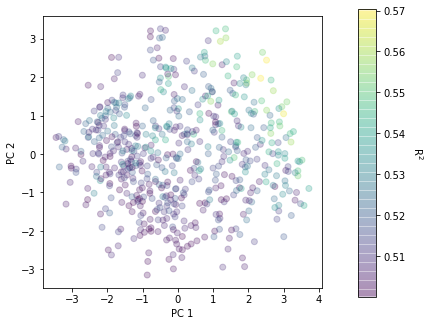

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

scatter = ax.scatter(PCA_Y[:,0], PCA_Y[:,1], alpha=0.25, c=compiled_df['R2'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

cax = fig.add_axes([1, 0.1, 0.05, 0.8])
fig.colorbar(scatter, cax=cax)
cax.set_ylabel('R$^{2}$', rotation=270, labelpad=20)

plt.show(fig)

## Lithology

The lithology masks and cell areas:

In [19]:
path = '../Output/'

lith_mask_ctrl = Dataset(path+'lith_mask_360_720.nc')

lith_mask_noIA = Dataset(path+'lith_mask_noIA.nc')

lith_mask_redIA = Dataset(path+'lith_mask_redIA.nc')
lith_mask_redIAsunda = Dataset(path+'lith_mask_redIAsunda.nc')

lith_mask_redIA5 = Dataset(path+'lith_mask_redIA5.nc')
lith_mask_redIAsunda5 = Dataset(path+'lith_mask_redIAsunda5.nc')

lith_mask_redIA10 = Dataset(path+'lith_mask_redIA10.nc')
lith_mask_redIAsunda10 = Dataset(path+'lith_mask_redIAsunda10.nc')

cell_area = Dataset(path+'cell_area_360_720.nc')

land_area_ctrl = Dataset(path+'land_area_360_720.nc')
land_area_noIA = Dataset(path+'land_area_noIA.nc')
land_area_redIA = Dataset(path+'land_area_redIA.nc')
land_area_redIAsunda = Dataset(path+'land_area_redIAsunda.nc')
land_area_redIA5 = Dataset(path+'land_area_redIA5.nc')
land_area_redIAsunda5 = Dataset(path+'land_area_redIAsunda5.nc')
land_area_redIA10 = Dataset(path+'land_area_redIA10.nc')
land_area_redIAsunda10 = Dataset(path+'land_area_redIAsunda10.nc')

In [20]:
lith_mask_ctrl.variables.keys()

dict_keys(['lon', 'lat', 'lith', 'frac'])

In [21]:
cell_area.variables.keys()

dict_keys(['lon', 'lat', 'area'])

In [22]:
land_area_ctrl.variables.keys()

dict_keys(['lon', 'lat', 'area'])

The mask that includes all land masses that we consider part of the Indonesia Archipelago:

In [23]:
drive_path = '/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/'

IA_mask_nc = Dataset(drive_path + 'Land_Masks/IA_mask.nc')
IA_mask = IA_mask_nc.variables['Band1'][:,:].data
IA_mask[np.isnan(IA_mask)] = 0
IA_mask[IA_mask > 1e30] = 0

Extract area information about each of the lithologies:

In [24]:
# the number of lithologies, excluding the ocean
n_liths = len(lith_mask_ctrl.variables['lith']) - 1

# extract total lithology area for each scenario
global_lith_area = np.zeros(n_liths)
ctrl_lith_area = np.zeros(n_liths)
noIA_lith_area = np.zeros(n_liths)
redIA_lith_area = np.zeros(n_liths)
redIAsunda_lith_area = np.zeros(n_liths)
redIA5_lith_area = np.zeros(n_liths)
redIAsunda5_lith_area = np.zeros(n_liths)
redIA10_lith_area = np.zeros(n_liths)
redIAsunda10_lith_area = np.zeros(n_liths)

for i in range(1,n_liths+1):
    global_lith_area[i-1] = np.sum(lith_mask_ctrl.variables['frac'][i,:,:].data *\
                                   cell_area.variables['area'][:,:].data)
    ctrl_lith_area[i-1] = np.sum(lith_mask_ctrl.variables['frac'][i,:,:].data * IA_mask *\
                                 cell_area.variables['area'][:,:].data)
    noIA_lith_area[i-1] = np.sum(lith_mask_noIA.variables['frac'][i,:,:].data * IA_mask *\
                                 cell_area.variables['area'][:,:].data)
    redIA_lith_area[i-1] = np.sum(lith_mask_redIA.variables['frac'][i,:,:].data * IA_mask *\
                                  cell_area.variables['area'][:,:].data)
    redIAsunda_lith_area[i-1] = np.sum(lith_mask_redIAsunda.variables['frac'][i,:,:].data * IA_mask *\
                                       cell_area.variables['area'][:,:].data)
    redIA5_lith_area[i-1] = np.sum(lith_mask_redIA5.variables['frac'][i,:,:].data * IA_mask *\
                                   cell_area.variables['area'][:,:].data)
    redIAsunda5_lith_area[i-1] = np.sum(lith_mask_redIAsunda5.variables['frac'][i,:,:].data * IA_mask *\
                                        cell_area.variables['area'][:,:].data)
    redIA10_lith_area[i-1] = np.sum(lith_mask_redIA10.variables['frac'][i,:,:].data * IA_mask *\
                                    cell_area.variables['area'][:,:].data)
    redIAsunda10_lith_area[i-1] = np.sum(lith_mask_redIAsunda10.variables['frac'][i,:,:].data * IA_mask *\
                                         cell_area.variables['area'][:,:].data)

Total areas:

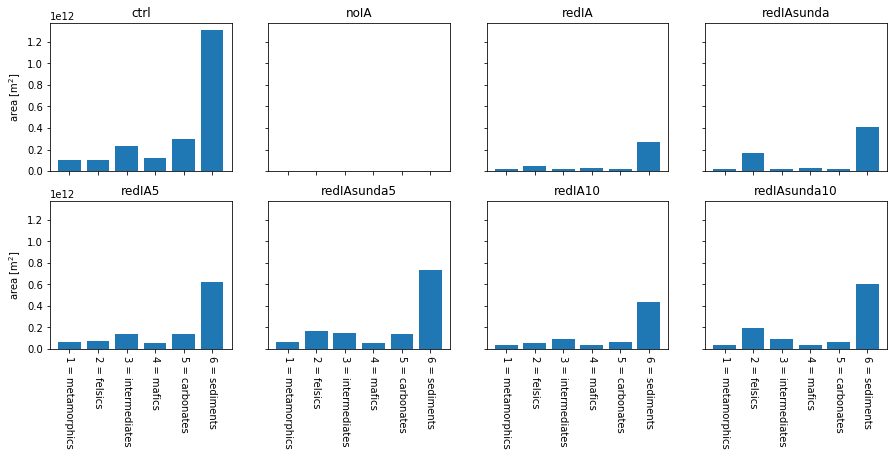

In [25]:
lith_class = ['1 = metamorphics',
              '2 = felsics',
              '3 = intermediates',
              '4 = mafics',
              '5 = carbonates',
              '6 = sediments']

# plot
scenario_lith_area_list = [ctrl_lith_area,
                           noIA_lith_area,
                           redIA_lith_area,
                           redIAsunda_lith_area,
                           redIA5_lith_area,
                           redIAsunda5_lith_area,
                           redIA10_lith_area,
                           redIAsunda10_lith_area]
scenario_name_list = ['ctrl',
                      'noIA',
                      'redIA',
                      'redIAsunda',
                      'redIA5',
                      'redIAsunda5',
                      'redIA10',
                      'redIAsunda10']

fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(15,6))

ax = ax.flatten()

x_inds = np.arange(n_liths)

for i in range(len(scenario_lith_area_list)):
    ax[i].bar(x_inds, scenario_lith_area_list[i])
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list[i])
    
ax[0].set_ylabel('area [m$^{2}$]')
ax[4].set_ylabel('area [m$^{2}$]')
    
plt.show(fig)

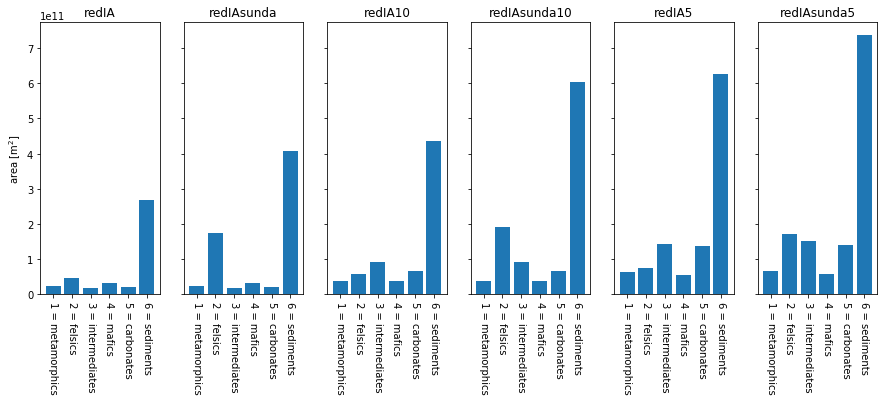

In [26]:
# plot
scenario_lith_area_list_mini = [redIA_lith_area,
                                redIAsunda_lith_area,
                                redIA10_lith_area,
                                redIAsunda10_lith_area,
                                redIA5_lith_area,
                                redIAsunda5_lith_area]
scenario_name_list_mini = ['redIA',
                           'redIAsunda',
                           'redIA10',
                           'redIAsunda10',
                           'redIA5',
                           'redIAsunda5']

fig, ax = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(15,5))

x_inds = np.arange(n_liths)

for i in range(len(scenario_lith_area_list_mini)):
    ax[i].bar(x_inds, scenario_lith_area_list_mini[i])
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list_mini[i])
    
ax[0].set_ylabel('area [m$^{2}$]')
    
plt.show(fig)

Fractional areas:

/Users/yuempark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


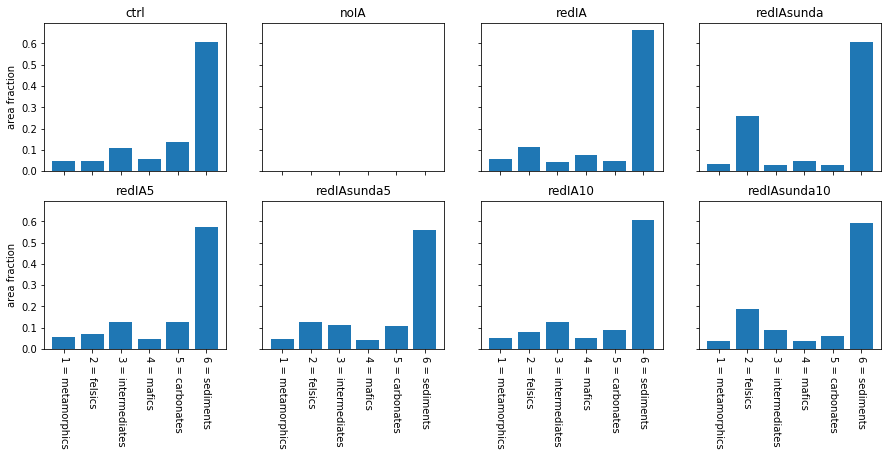

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(15,6))

ax = ax.flatten()

for i in range(len(scenario_lith_area_list)):
    ax[i].bar(x_inds, scenario_lith_area_list[i]/np.sum(scenario_lith_area_list[i]))
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list[i])
    
ax[0].set_ylabel('area fraction')
ax[4].set_ylabel('area fraction')
    
plt.show(fig)

Change relative to the control:

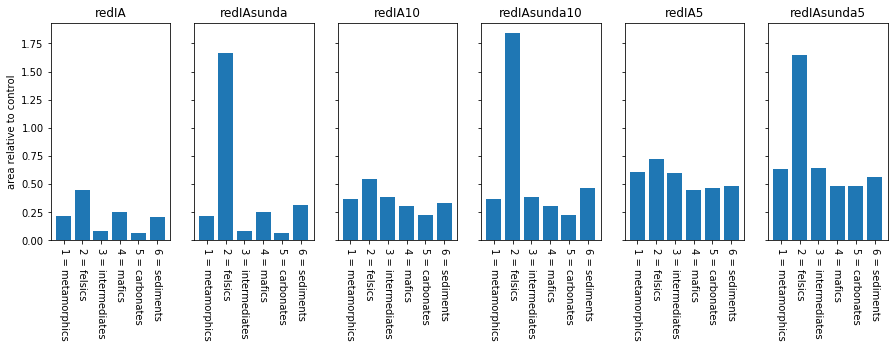

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(15,4))

x_inds = np.arange(n_liths)

for i in range(len(scenario_lith_area_list_mini)):
    ax[i].bar(x_inds, scenario_lith_area_list_mini[i]/ctrl_lith_area)
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list_mini[i])
    
ax[0].set_ylabel('area relative to control')
    
plt.show(fig)

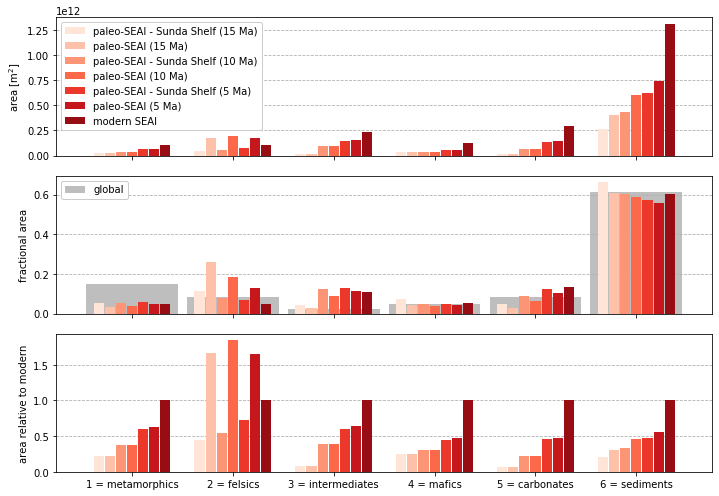

In [29]:
# plot
scenario_lith_area_list = [redIA_lith_area,
                           redIAsunda_lith_area,
                           redIA10_lith_area,
                           redIAsunda10_lith_area,
                           redIA5_lith_area,
                           redIAsunda5_lith_area,
                           ctrl_lith_area]
scenario_name_list = ['paleo-SEAI - Sunda Shelf (15 Ma)',
                      'paleo-SEAI (15 Ma)',
                      'paleo-SEAI - Sunda Shelf (10 Ma)',
                      'paleo-SEAI (10 Ma)',
                      'paleo-SEAI - Sunda Shelf (5 Ma)',
                      'paleo-SEAI (5 Ma)',
                      'modern SEAI']

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,7))

x_inds = np.arange(n_liths)
width = 0.1
gap = 0.01

cmap = matplotlib.cm.get_cmap('Reds')
cmap_inds = np.linspace(0.1,0.9,len(scenario_lith_area_list))

for i in range(len(scenario_lith_area_list)):
    ax[0].bar(x_inds + width*i + gap*i, scenario_lith_area_list[i],
              width, facecolor=cmap(cmap_inds[i]), label=scenario_name_list[i])
    ax[1].bar(x_inds + width*i + gap*i, scenario_lith_area_list[i]/np.sum(scenario_lith_area_list[i]),
              width, facecolor=cmap(cmap_inds[i]), label='__nolegend__')
    ax[2].bar(x_inds + width*i + gap*i, scenario_lith_area_list[i]/ctrl_lith_area,
              width, facecolor=cmap(cmap_inds[i]), label='__nolegend__')
    
ax[1].bar(x_inds + gap*3 + width*3, global_lith_area/np.sum(global_lith_area),
          width*len(scenario_lith_area_list) + gap*(len(scenario_lith_area_list)-1) + 0.15,
          facecolor='C7', alpha=0.5, zorder=-99, label='global')

ax[0].legend(framealpha=1)
ax[1].legend(framealpha=1)
ax[0].set_ylabel('area [m$^{2}$]')
ax[1].set_ylabel('fractional area')
ax[2].set_ylabel('area relative to modern')

ax[2].set_xticks(x_inds + gap*3 + width*3)
ax[2].set_xticklabels(lith_class)

for i in range(3):
    ax[i].grid(axis='y', ls='--')
    ax[i].set_axisbelow(True)
    
fig.tight_layout()
#fig.savefig('../../Manuscript/Figures/lithology_areas.pdf', bbox_inches='tight')
plt.show(fig)

## CO$_{2}$ Consumption

In [30]:
# extract the weathering maps
ctrl_weathering = control_nc.variables['weathering'][:,:,:].data[inds_0_5]
redIA_weathering = redIA_nc.variables['weathering'][:,:,:].data[inds_0_5]
redIA10_weathering = redIA10_nc.variables['weathering'][:,:,:].data[inds_0_5]
redIA5_weathering = redIA5_nc.variables['weathering'][:,:,:].data[inds_0_5]
redIAsunda_weathering = redIAsunda_nc.variables['weathering'][:,:,:].data[inds_0_5]
redIAsunda10_weathering = redIAsunda10_nc.variables['weathering'][:,:,:].data[inds_0_5]
redIAsunda5_weathering = redIAsunda5_nc.variables['weathering'][:,:,:].data[inds_0_5]

# set fill value to 0
ctrl_weathering[ctrl_weathering > 1e30] = 0
redIA_weathering[redIA_weathering > 1e30] = 0
redIA10_weathering[redIA10_weathering > 1e30] = 0
redIA5_weathering[redIA5_weathering > 1e30] = 0
redIAsunda_weathering[redIAsunda_weathering > 1e30] = 0
redIAsunda10_weathering[redIAsunda10_weathering > 1e30] = 0
redIAsunda5_weathering[redIAsunda5_weathering > 1e30] = 0

# the number of runs
n_runs = np.shape(ctrl_weathering)[0]

# convert from mol/m2/yr to mol/yr
for i in tqdm(range(n_runs), desc='sum area', leave=True):
    ctrl_weathering[i,:,:] = ctrl_weathering[i,:,:] * land_area_ctrl.variables['area'][:,:].data
    redIA_weathering[i,:,:] = redIA_weathering[i,:,:] * land_area_redIA.variables['area'][:,:].data
    redIA10_weathering[i,:,:] = redIA10_weathering[i,:,:] * land_area_redIA10.variables['area'][:,:].data
    redIA5_weathering[i,:,:] = redIA5_weathering[i,:,:] * land_area_redIA5.variables['area'][:,:].data
    redIAsunda_weathering[i,:,:] = redIAsunda_weathering[i,:,:] * land_area_redIAsunda.variables['area'][:,:].data
    redIAsunda10_weathering[i,:,:] = redIAsunda10_weathering[i,:,:] * land_area_redIAsunda10.variables['area'][:,:].data
    redIAsunda5_weathering[i,:,:] = redIAsunda5_weathering[i,:,:] * land_area_redIAsunda5.variables['area'][:,:].data

# extract total CO2 consumption in IA for each scenario
ctrl_IA_CO2 = np.zeros(n_runs)
redIA_IA_CO2 = np.zeros(n_runs)
redIA10_IA_CO2 = np.zeros(n_runs)
redIA5_IA_CO2 = np.zeros(n_runs)
redIAsunda_IA_CO2 = np.zeros(n_runs)
redIAsunda10_IA_CO2 = np.zeros(n_runs)
redIAsunda5_IA_CO2 = np.zeros(n_runs)

for i in tqdm(range(n_runs), desc='run loop', leave=True):
    ctrl_IA_CO2[i] = np.sum(ctrl_weathering[i,:,:] * IA_mask) / np.sum(ctrl_weathering[i,:,:])
    redIA_IA_CO2[i] = np.sum(redIA_weathering[i,:,:] * IA_mask) / np.sum(redIA_weathering[i,:,:])
    redIA10_IA_CO2[i] = np.sum(redIA10_weathering[i,:,:] * IA_mask) / np.sum(redIA10_weathering[i,:,:])
    redIA5_IA_CO2[i] = np.sum(redIA5_weathering[i,:,:] * IA_mask) / np.sum(redIA5_weathering[i,:,:])
    redIAsunda_IA_CO2[i] = np.sum(redIAsunda_weathering[i,:,:] * IA_mask) / np.sum(redIAsunda_weathering[i,:,:])
    redIAsunda10_IA_CO2[i] = np.sum(redIAsunda10_weathering[i,:,:] * IA_mask) / np.sum(redIAsunda10_weathering[i,:,:])
    redIAsunda5_IA_CO2[i] = np.sum(redIAsunda5_weathering[i,:,:] * IA_mask) / np.sum(redIAsunda5_weathering[i,:,:])

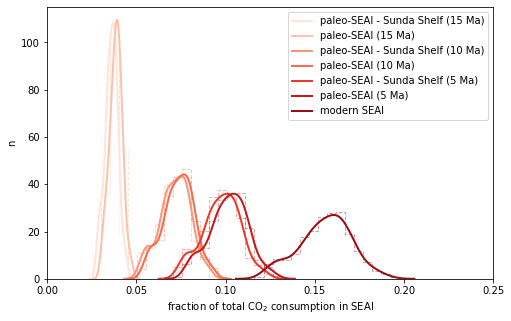

In [31]:
scenario_IA_CO2_frac_list = [redIA_IA_CO2,
                             redIAsunda_IA_CO2,
                             redIA10_IA_CO2,
                             redIAsunda10_IA_CO2,
                             redIA5_IA_CO2,
                             redIAsunda5_IA_CO2,
                             ctrl_IA_CO2]
scenario_name_list = ['paleo-SEAI - Sunda Shelf (15 Ma)',
                      'paleo-SEAI (15 Ma)',
                      'paleo-SEAI - Sunda Shelf (10 Ma)',
                      'paleo-SEAI (10 Ma)',
                      'paleo-SEAI - Sunda Shelf (5 Ma)',
                      'paleo-SEAI (5 Ma)',
                      'modern SEAI']

fig, ax = plt.subplots(figsize=(8,5))

cmap = matplotlib.cm.get_cmap('Reds')
cmap_inds = np.linspace(0.1,0.9,len(scenario_IA_CO2_frac_list))

bins = np.linspace(0, 0.5, 100)

for i in range(len(scenario_IA_CO2_frac_list)):
    
    sns.distplot(scenario_IA_CO2_frac_list[i], bins=bins,
                 hist_kws={'color':cmap(cmap_inds[i]), 'linestyle':'--', 'histtype':'step'},
                 kde_kws={'color':cmap(cmap_inds[i]), 'linewidth':2, 'label':scenario_name_list[i]},
                 ax=ax)

ax.set_xlabel('fraction of total CO$_{2}$ consumption in SEAI')
ax.set_ylabel('n')
ax.set_xlim(0,0.25)
ax.legend()

#fig.savefig('../../Manuscript/Figures/SEAI_CO2_consumption.pdf', bbox_inches='tight')
plt.show(fig)

## pCO$_{2}$ Proxies

In [32]:
# data from Foster et al. (2017) compilation
pCO2_alkenones = pd.read_csv('../Input/pCO2/Foster2017a_alkenones.csv')
pCO2_boron = pd.read_csv('../Input/pCO2/Foster2017a_boron.csv')
pCO2_liverworts = pd.read_csv('../Input/pCO2/Foster2017a_liverworts.csv')
pCO2_paleosols = pd.read_csv('../Input/pCO2/Foster2017a_paleosols.csv')
pCO2_stomat = pd.read_csv('../Input/pCO2/Foster2017a_stomat.csv')

pCO2_all = pd.concat([pCO2_alkenones,pCO2_boron,pCO2_liverworts,pCO2_paleosols,pCO2_stomat], ignore_index=True)

pCO2_LOESS = pd.read_csv('../Input/pCO2/Foster2017a_LOESS.csv')

# data from Bereiter et al. (2015) EPICA Dome C
pCO2_EPICA = pd.read_csv('../Input/pCO2/Bereiter2015a.csv')

# data from Ji et al. (2018) paleosols
pCO2_Ji = pd.read_csv('../Input/pCO2/Ji2018a.csv')
pCO2_Ji = pCO2_Ji[pCO2_Ji['source']=='Ji et al. (2018)']

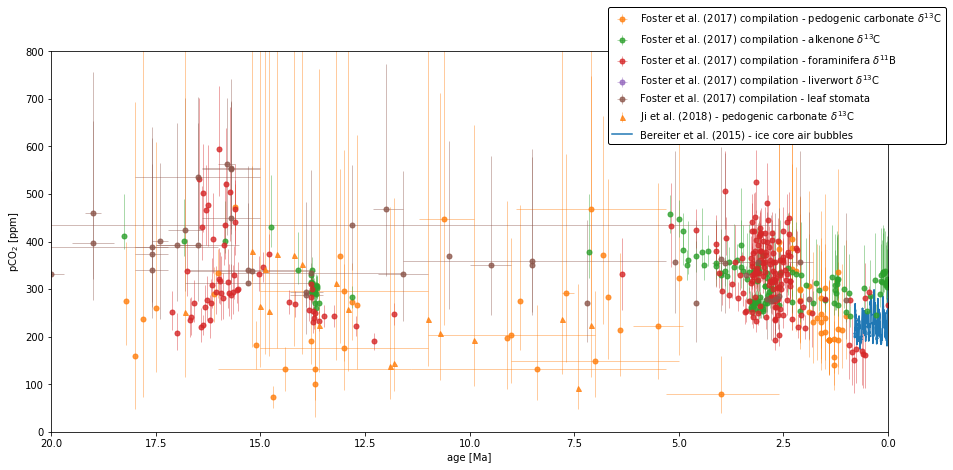

In [33]:
fig, ax = plt.subplots(figsize=(15,7))

markersize = 5

h1 = ax.errorbar(pCO2_paleosols['Age_Ma'], pCO2_paleosols['CO2_ppm'],
                 xerr=[pCO2_paleosols['Age_Ma']-pCO2_paleosols['Age_young'], pCO2_paleosols['Age_old']-pCO2_paleosols['Age_Ma']],
                 yerr=[pCO2_paleosols['CO2_ppm']-pCO2_paleosols['CO2_low'], pCO2_paleosols['CO2_high']-pCO2_paleosols['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C1', marker='o', markersize=markersize,
                 label='Foster et al. (2017) compilation - pedogenic carbonate $\delta^{13}$C')
h2 = ax.errorbar(pCO2_alkenones['Age_Ma'], pCO2_alkenones['CO2_ppm'],
                 xerr=[pCO2_alkenones['Age_Ma']-pCO2_alkenones['Age_young'], pCO2_alkenones['Age_old']-pCO2_alkenones['Age_Ma']],
                 yerr=[pCO2_alkenones['CO2_ppm']-pCO2_alkenones['CO2_low'], pCO2_alkenones['CO2_high']-pCO2_alkenones['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C2', marker='o', markersize=markersize,
                 label='Foster et al. (2017) compilation - alkenone $\delta^{13}$C')
h3 = ax.errorbar(pCO2_boron['Age_Ma'], pCO2_boron['CO2_ppm'],
                 xerr=[pCO2_boron['Age_Ma']-pCO2_boron['Age_young'], pCO2_boron['Age_old']-pCO2_boron['Age_Ma']],
                 yerr=[pCO2_boron['CO2_ppm']-pCO2_boron['CO2_low'], pCO2_boron['CO2_high']-pCO2_boron['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C3', marker='o', markersize=markersize,
                 label='Foster et al. (2017) compilation - foraminifera $\delta^{11}$B')
h4 = ax.errorbar(pCO2_liverworts['Age_Ma'], pCO2_liverworts['CO2_ppm'],
                 xerr=[pCO2_liverworts['Age_Ma']-pCO2_liverworts['Age_young'], pCO2_liverworts['Age_old']-pCO2_liverworts['Age_Ma']],
                 yerr=[pCO2_liverworts['CO2_ppm']-pCO2_liverworts['CO2_low'], pCO2_liverworts['CO2_high']-pCO2_liverworts['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C4', marker='o', markersize=markersize,
                 label='Foster et al. (2017) compilation - liverwort $\delta^{13}$C')
h5 = ax.errorbar(pCO2_stomat['Age_Ma'], pCO2_stomat['CO2_ppm'],
                 xerr=[pCO2_stomat['Age_Ma']-pCO2_stomat['Age_young'], pCO2_stomat['Age_old']-pCO2_stomat['Age_Ma']],
                 yerr=[pCO2_stomat['CO2_ppm']-pCO2_stomat['CO2_low'], pCO2_stomat['CO2_high']-pCO2_stomat['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C5', marker='o', markersize=markersize,
                 label='Foster et al. (2017) compilation - leaf stomata')

h6 = ax.errorbar(pCO2_Ji['Age_Ma'], pCO2_Ji['pCO2_median'],
                 yerr=[pCO2_Ji['pCO2_16'], pCO2_Ji['pCO2_84']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C1', marker='^', markersize=markersize,
                 label='Ji et al. (2018) - pedogenic carbonate $\delta^{13}$C')

h7 = ax.plot(pCO2_EPICA['age_yr']/1e6, pCO2_EPICA['CO2_ppm'],
             label='Bereiter et al. (2015) - ice core air bubbles')

ax.set_xlim(20,0)
ax.set_xlabel('age [Ma]')

ax.set_ylim(0,800)
ax.set_ylabel('pCO$_{2}$ [ppm]')

ax.legend(handles=[h1,h2,h3,h4,h5,h6,h7[0]],
          edgecolor='k',facecolor='white',loc='upper left',bbox_to_anchor=(0.66,1.13),framealpha=1)

#fig.savefig('../../Manuscript/Figures/pCO2_proxies.pdf',bbox_inches='tight')
plt.show(fig)

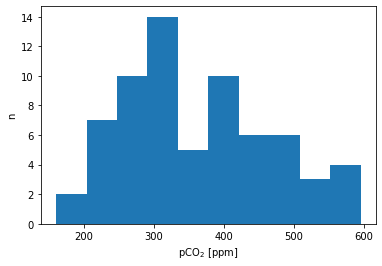

In [34]:
fig, ax = plt.subplots()

ax.hist(pCO2_all[(pCO2_all['Age_Ma']>15)&(pCO2_all['Age_Ma']<20)]['CO2_ppm'])

ax.set_xlabel('pCO$_{2}$ [ppm]')
ax.set_ylabel('n')

plt.show(fig)

## Box Plot

In [35]:
# I&NG with Sunda and Greenland
sns_df_1 = pd.DataFrame({'ppm':compiled_df['redIAsundaGL_ppm'].values,
                         'scenario':['redIAsundaGL']*n_runs})

sns_df_2 = pd.DataFrame({'ppm':compiled_df['redIAsunda10GL_ppm'].values,
                         'scenario':['redIAsunda10GL']*n_runs})

sns_df_3 = pd.DataFrame({'ppm':compiled_df['redIAsunda5GL_ppm'].values,
                         'scenario':['redIAsunda5GL']*n_runs})

# I&NG with Sunda
sns_df_4 = pd.DataFrame({'ppm':compiled_df['redIAsunda_ppm'].values,
                         'scenario':['redIAsunda']*n_runs})

sns_df_5 = pd.DataFrame({'ppm':compiled_df['redIAsunda10_ppm'].values,
                         'scenario':['redIAsunda10']*n_runs})

sns_df_6 = pd.DataFrame({'ppm':compiled_df['redIAsunda5_ppm'].values,
                         'scenario':['redIAsunda5']*n_runs})

# I&NG without Sunda
sns_df_7 = pd.DataFrame({'ppm':compiled_df['redIA_ppm'].values,
                         'scenario':['redIA']*n_runs})

sns_df_8 = pd.DataFrame({'ppm':compiled_df['redIA10_ppm'].values,
                         'scenario':['redIA10']*n_runs})

sns_df_9 = pd.DataFrame({'ppm':compiled_df['redIA5_ppm'].values,
                         'scenario':['redIA5']*n_runs})

# no I&NG
sns_df_10 = pd.DataFrame({'ppm':compiled_df['noIA_ppm'].values,
                          'scenario':['noIA']*n_runs})

# Traps
sns_df_11 = pd.DataFrame({'ppm':compiled_df['noDeccan_ppm'].values,
                          'scenario':['noDeccan']*n_runs})

sns_df_12 = pd.DataFrame({'ppm':compiled_df['noET_ppm'].values,
                          'scenario':['noET']*n_runs})

sns_df_13 = pd.DataFrame({'ppm':compiled_df['noTraps_ppm'].values,
                           'scenario':['noTraps']*n_runs})

sns_df_14 = pd.DataFrame({'ppm':compiled_df['noCRB_ppm'].values,
                           'scenario':['noCRB']*n_runs})

sns_df = pd.concat([sns_df_1,
                    sns_df_2,
                    sns_df_3,
                    sns_df_4,
                    sns_df_5,
                    sns_df_6,
                    sns_df_7,
                    sns_df_8,
                    sns_df_9,
                    sns_df_10,
                    sns_df_11,
                    sns_df_12,
                    sns_df_13,
                    sns_df_14], ignore_index=True)

sns_df_scenario_list = ['redIAsundaGL',
                        'redIAsunda10GL',
                        'redIAsunda5GL',
                        'redIAsunda',
                        'redIAsunda10',
                        'redIAsunda5',
                        'redIA',
                        'redIA10',
                        'redIA5',
                        'noIA',
                        'noDeccan',
                        'noET',
                        'noTraps',
                        'noCRB']

In [36]:
scenario_stats_name = []
scenario_stats_mean = np.array([])
scenario_stats_2sigma = np.array([])
scenario_stats_min = np.array([])
scenario_stats_max = np.array([])
scenario_stats_02_5 = np.array([])
scenario_stats_05_0 = np.array([])
scenario_stats_95_0 = np.array([])
scenario_stats_97_5 = np.array([])

for i in range(len(sns_df_scenario_list)):
    sns_df_slice = sns_df[sns_df['scenario']==sns_df_scenario_list[i]]
    
    scenario_stats_name.append(sns_df_scenario_list[i])
    scenario_stats_mean = np.append(scenario_stats_mean, np.mean(sns_df_slice['ppm']))
    scenario_stats_2sigma = np.append(scenario_stats_2sigma, 2*np.std(sns_df_slice['ppm']))
    scenario_stats_min = np.append(scenario_stats_min, np.min(sns_df_slice['ppm']))
    scenario_stats_max = np.append(scenario_stats_max, np.max(sns_df_slice['ppm']))
    scenario_stats_02_5 = np.append(scenario_stats_02_5, np.percentile(sns_df_slice['ppm'], 2.5))
    scenario_stats_05_0 = np.append(scenario_stats_05_0, np.percentile(sns_df_slice['ppm'], 5))
    scenario_stats_95_0 = np.append(scenario_stats_95_0, np.percentile(sns_df_slice['ppm'], 95))
    scenario_stats_97_5 = np.append(scenario_stats_97_5, np.percentile(sns_df_slice['ppm'], 97.5))
    
scenario_stats = pd.DataFrame({'scenario':scenario_stats_name,
                               'mean':scenario_stats_mean,
                               '2sigma':scenario_stats_2sigma,
                               'min':scenario_stats_min,
                               'max':scenario_stats_max,
                               '02_5':scenario_stats_02_5,
                               '05_0':scenario_stats_05_0,
                               '95_0':scenario_stats_95_0,
                               '97_5':scenario_stats_97_5})

scenario_stats

,scenario,mean,2sigma,min,max,02_5,05_0,95_0,97_5
0,redIAsundaGL,604.328082,78.930803,525.98520,677.70135,531.924708,539.009340,661.597520,666.884300
1,redIAsunda10GL,493.365952,28.669704,457.28778,516.30400,461.497540,466.650560,512.883380,514.129063
2,redIAsunda5GL,414.278058,19.580123,391.08350,433.99640,393.907494,396.024334,428.620360,429.659359
3,redIAsunda,612.930142,82.842559,529.17340,686.50460,536.336565,543.687240,671.065768,676.256220
4,redIAsunda10,497.589447,28.857058,460.03170,520.37024,465.607924,470.525968,517.121636,518.101885
5,redIAsunda5,417.890544,19.716969,393.44623,437.82500,396.875635,399.918406,432.434924,433.034680
6,redIA,646.058105,88.521266,553.51140,720.84240,560.110085,566.193896,702.492676,707.460430
7,redIA10,517.069612,26.057081,483.64145,536.69760,489.320102,492.274920,534.029080,535.270520
8,redIA5,436.311720,18.798057,413.67166,453.83942,417.078520,418.804680,450.143002,450.714650
9,noIA,805.154500,113.022299,669.61676,898.52600,687.749970,699.118284,874.943096,881.628452


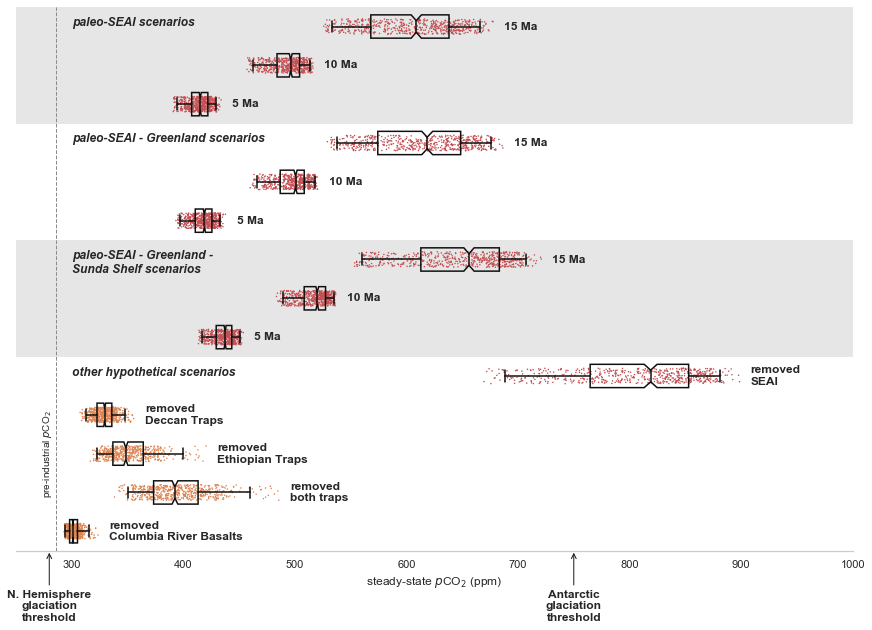

In [37]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(15,10))

# plot the data
sns.stripplot(x='ppm', y='scenario', data=sns_df, palette=['C3','C3','C3',
                                                           'C3','C3','C3',
                                                           'C3','C3','C3',
                                                           'C3','C1','C1','C1','C1'],
              dodge=True, jitter=0.2, alpha=1, size=1.5, zorder=-99)

sns.boxplot(x='ppm', y='scenario', data=sns_df, color='k',
            fliersize=0, width=0.6, notch=True, whis=(2.5,97.5), zorder=99)

for patch in ax.artists:
    r,g,b,a = patch.get_facecolor()
    patch.set_facecolor((0,0,0,0))

# add labels for each scenario
fontsize = 12
ax.text(np.max(compiled_df['redIAsundaGL_ppm'])+10, 0,
        '15 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda10GL_ppm'])+10, 1,
        '10 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda5GL_ppm'])+10, 2,
        '5 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.text(np.max(compiled_df['redIAsunda_ppm'])+10, 3,
        '15 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda10_ppm'])+10, 4,
        '10 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda5_ppm'])+10, 5,
        '5 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.text(np.max(compiled_df['redIA_ppm'])+10, 6,
        '15 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIA10_ppm'])+10, 7,
        '10 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIA5_ppm'])+10, 8,
        '5 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.text(np.max(compiled_df['noIA_ppm'])+10, 9,
        'removed\nSEAI', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.text(np.max(compiled_df['noDeccan_ppm'])+10, 10,
        'removed\nDeccan Traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['noET_ppm'])+10, 11,
        'removed\nEthiopian Traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['noTraps_ppm'])+10, 12,
        'removed\nboth traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['noCRB_ppm'])+10, 13,
        'removed\nColumbia River Basalts', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

# clean up the axes
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('steady-state $\it{p}$CO$_{2}$ (ppm)')

ax.set_xlim(250,1000)
ax.set_xticks([300,400,500,600,700,800,900,1000])

# additional labels
rect = patches.Rectangle((250,-0.5),750,3,
                         edgecolor='none',facecolor=(0.9,0.9,0.9),zorder=-999)
ax.add_patch(rect)

rect = patches.Rectangle((250,5.5),750,3,
                         edgecolor='none',facecolor=(0.9,0.9,0.9),zorder=-999)
ax.add_patch(rect)

ax.axvline(286, c='C7', lw=1, ls='--')
ax.text(284, 11, 'pre-industrial $\it{p}$CO$_{2}$', fontsize=10,
        horizontalalignment='right', verticalalignment='center', rotation=90)

ax.text(300, -0.25, 'paleo-SEAI scenarios',
        fontsize=12, style='italic', fontweight='bold',
        horizontalalignment='left', verticalalignment='top')
ax.text(300, 2.75, 'paleo-SEAI - Greenland scenarios',
        fontsize=12, style='italic', fontweight='bold',
        horizontalalignment='left', verticalalignment='top')
ax.text(300, 5.75, 'paleo-SEAI - Greenland -\nSunda Shelf scenarios',
        fontsize=12, style='italic', fontweight='bold',
        horizontalalignment='left', verticalalignment='top')
ax.text(300, 8.75, 'other hypothetical scenarios',
        fontsize=12, style='italic', fontweight='bold',
        horizontalalignment='left', verticalalignment='top')

ax.annotate("Antarctic\nglaciation\nthreshold", xy=(750, 13.5), xytext=(750, 14.5),
            arrowprops={'arrowstyle':"->", 'color':'k'},
            horizontalalignment='center', verticalalignment='top', fontweight='bold',)

ax.annotate("N. Hemisphere\nglaciation\nthreshold", xy=(280, 13.5), xytext=(280, 14.5),
            arrowprops={'arrowstyle':"->", 'color':'k'},
            horizontalalignment='center', verticalalignment='top', fontweight='bold',)

# final clean up
ax.xaxis.grid(False)
sns.despine(left=True)

#fig.savefig('../../Manuscript/Figures/scenario_pCO2_all.pdf',bbox_inches='tight')

plt.show(fig)

In [38]:
sns_df_mini = pd.concat([sns_df_1,
                         sns_df_2,
                         sns_df_3,
                         sns_df_10,
                         sns_df_11,
                         sns_df_12,
                         sns_df_13,
                         sns_df_14], ignore_index=True)

sns_df_scenario_list_mini = ['redIAsundaGL',
                             'redIAsunda10GL',
                             'redIAsunda5GL',
                             'noIA',
                             'noDeccan',
                             'noET',
                             'noTraps',
                             'noCRB']

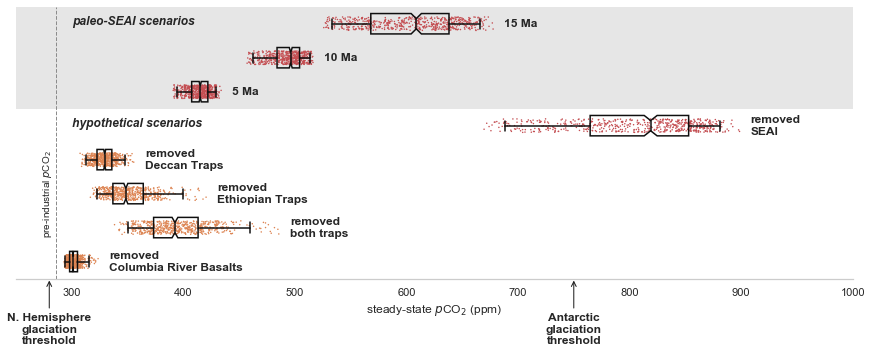

In [39]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(15,5))

# plot the data
sns.stripplot(x='ppm', y='scenario', data=sns_df_mini, palette=['C3','C3','C3','C3','C1','C1','C1','C1'],
              dodge=True, jitter=0.2, alpha=1, size=1.5, zorder=-99)

sns.boxplot(x='ppm', y='scenario', data=sns_df_mini, color='k',
            fliersize=0, width=0.6, notch=True, whis=(2.5,97.5), zorder=99)

for patch in ax.artists:
    r,g,b,a = patch.get_facecolor()
    patch.set_facecolor((0,0,0,0))

# add labels for each scenario
fontsize = 12
ax.text(np.max(compiled_df['redIAsundaGL_ppm'])+10, 0,
        '15 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda10GL_ppm'])+10, 1,
        '10 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda5GL_ppm'])+10, 2,
        '5 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.text(np.max(compiled_df['noIA_ppm'])+10, 3,
        'removed\nSEAI', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.text(np.max(compiled_df['noDeccan_ppm'])+10, 4,
        'removed\nDeccan Traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['noET_ppm'])+10, 5,
        'removed\nEthiopian Traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['noTraps_ppm'])+10, 6,
        'removed\nboth traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['noCRB_ppm'])+10, 7,
        'removed\nColumbia River Basalts', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

# clean up the axes
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('steady-state $\it{p}$CO$_{2}$ (ppm)')

ax.set_xlim(250,1000)
ax.set_xticks([300,400,500,600,700,800,900,1000])

# additional labels
rect = patches.Rectangle((250,-0.5),750,3,
                         edgecolor='none',facecolor=(0.9,0.9,0.9),zorder=-999)
ax.add_patch(rect)

ax.axvline(286, c='C7', lw=1, ls='--')
ax.text(284, 5, 'pre-industrial $\it{p}$CO$_{2}$', fontsize=10,
        horizontalalignment='right', verticalalignment='center', rotation=90)

ax.text(300, -0.25, 'paleo-SEAI scenarios',
        fontsize=12, style='italic', fontweight='bold',
        horizontalalignment='left', verticalalignment='top')
ax.text(300, 2.75, 'hypothetical scenarios',
        fontsize=12, style='italic', fontweight='bold',
        horizontalalignment='left', verticalalignment='top')

ax.annotate("Antarctic\nglaciation\nthreshold", xy=(750, 7.5), xytext=(750, 8.5),
            arrowprops={'arrowstyle':"->", 'color':'k'},
            horizontalalignment='center', verticalalignment='top', fontweight='bold',)

ax.annotate("N. Hemisphere\nglaciation\nthreshold", xy=(280, 7.5), xytext=(280, 8.5),
            arrowprops={'arrowstyle':"->", 'color':'k'},
            horizontalalignment='center', verticalalignment='top', fontweight='bold',)

# final clean up
ax.xaxis.grid(False)
sns.despine(left=True)

#fig.savefig('../../Manuscript/Figures/scenario_pCO2.pdf',bbox_inches='tight')

plt.show(fig)

In [40]:
sns_df_mini_mini = pd.concat([sns_df_1,
                              sns_df_2,
                              sns_df_3], ignore_index=True)

sns_df_scenario_list_mini_mini = ['redIAsundaGL',
                                  'redIAsunda10GL',
                                  'redIAsunda5GL']

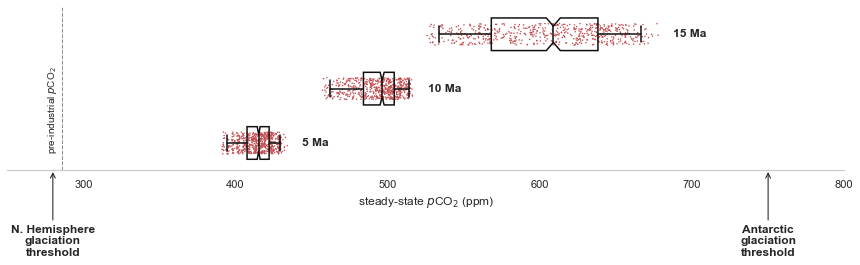

In [41]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(15,3))

# plot the data
sns.stripplot(x='ppm', y='scenario', data=sns_df_mini_mini, palette=['C3','C3','C3'],
              dodge=True, jitter=0.2, alpha=1, size=1.5, zorder=-99)

sns.boxplot(x='ppm', y='scenario', data=sns_df_mini_mini, color='k',
            fliersize=0, width=0.6, notch=True, whis=(2.5,97.5), zorder=99)

for patch in ax.artists:
    r,g,b,a = patch.get_facecolor()
    patch.set_facecolor((0,0,0,0))

# add labels for each scenario
fontsize = 12
ax.text(np.max(compiled_df['redIAsundaGL_ppm'])+10, 0,
        '15 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda10GL_ppm'])+10, 1,
        '10 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(compiled_df['redIAsunda5GL_ppm'])+10, 2,
        '5 Ma', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

# clean up the axes
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('steady-state $\it{p}$CO$_{2}$ (ppm)')

ax.set_xlim(250,800)
ax.set_xticks([300,400,500,600,700,800])

# additional labels

ax.axvline(286, c='C7', lw=1, ls='--')
ax.text(284, 1.4, 'pre-industrial $\it{p}$CO$_{2}$', fontsize=10,
        horizontalalignment='right', verticalalignment='center', rotation=90)

ax.annotate("Antarctic\nglaciation\nthreshold", xy=(750, 2.5), xytext=(750, 3.5),
            arrowprops={'arrowstyle':"->", 'color':'k'},
            horizontalalignment='center', verticalalignment='top', fontweight='bold',)

ax.annotate("N. Hemisphere\nglaciation\nthreshold", xy=(280, 2.5), xytext=(280, 3.5),
            arrowprops={'arrowstyle':"->", 'color':'k'},
            horizontalalignment='center', verticalalignment='top', fontweight='bold',)

# final clean up
ax.xaxis.grid(False)
sns.despine(left=True)

#fig.savefig('../../Manuscript/Figures/scenario_pCO2_mini.pdf',bbox_inches='tight')

plt.show(fig)